# estdel evaluation

In [1]:
import estdel

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [3]:
from estdel_nn.data_creation import data_manipulation as dm

## Construct test data from real data

### Load real data

In [4]:
red_bls, gains, uvd = dm.load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

Load (or generate) a list of redundant baselines and get their data

In [5]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = '../data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = '../data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

Find all the unique antennas

In [6]:
unique_ants = []
for key in _bl_dict.keys():
    for sep in _bl_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)

Assign each antenna a random cable delay in the range -0.010 to 0.010 (~ -100ns to +100ns)

In [7]:
generated_ant_delays = {ant : np.random.uniform(low = -0.010, high = 0.010) for ant in unique_ants}

The data and its conjugate

In [8]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

The gains and their conjugates

In [9]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

The tool we use to create a flat visibility ratio on which we can apply a delay

In [10]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [11]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

## Construct testing data

Generate 1000 visibility ratios. From each one take on random row for testing.

In [12]:
num_waterfalls = 1000
waterfalls = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_waterfalls):
    
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]        
    
    true_delay = get_target(two_seps, generated_ant_delays)
    targets.append(true_delay)

    waterfall = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    waterfalls.append(waterfall[np.random.randint(60)])
 

### To convert unitless targets back to ns

In [13]:
freqs = np.linspace(0.100,0.200,1024)

In [14]:
channel_width_in_GHz = np.mean(np.diff(freqs))

In [15]:
def scale_delays_to_ns(delays, channel_width_in_GHz = np.mean(np.diff(np.linspace(0.100,0.200,1024)))):
    return delays / channel_width_in_GHz

## Predict cable delays for data

In [16]:
predictor = estdel.Delay(waterfalls)
predictions = predictor.predict()

In [17]:
targets_ns = scale_delays_to_ns(np.array(targets), channel_width_in_GHz)

## Evaluate

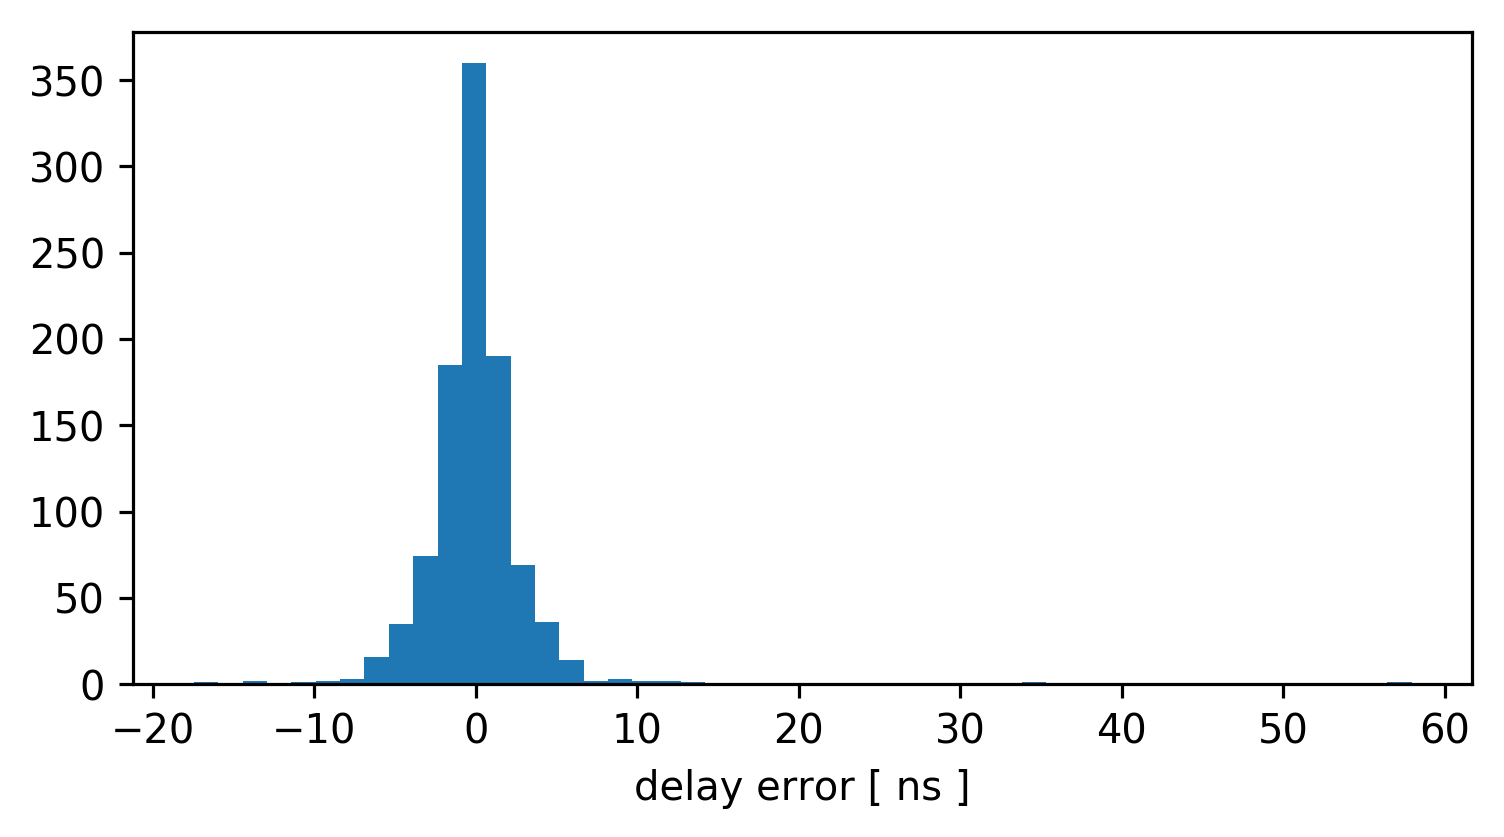

In [18]:
error = targets_ns - predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.hist(error, bins = 50)
plt.xlabel('delay error [ ns ]')
plt.show()

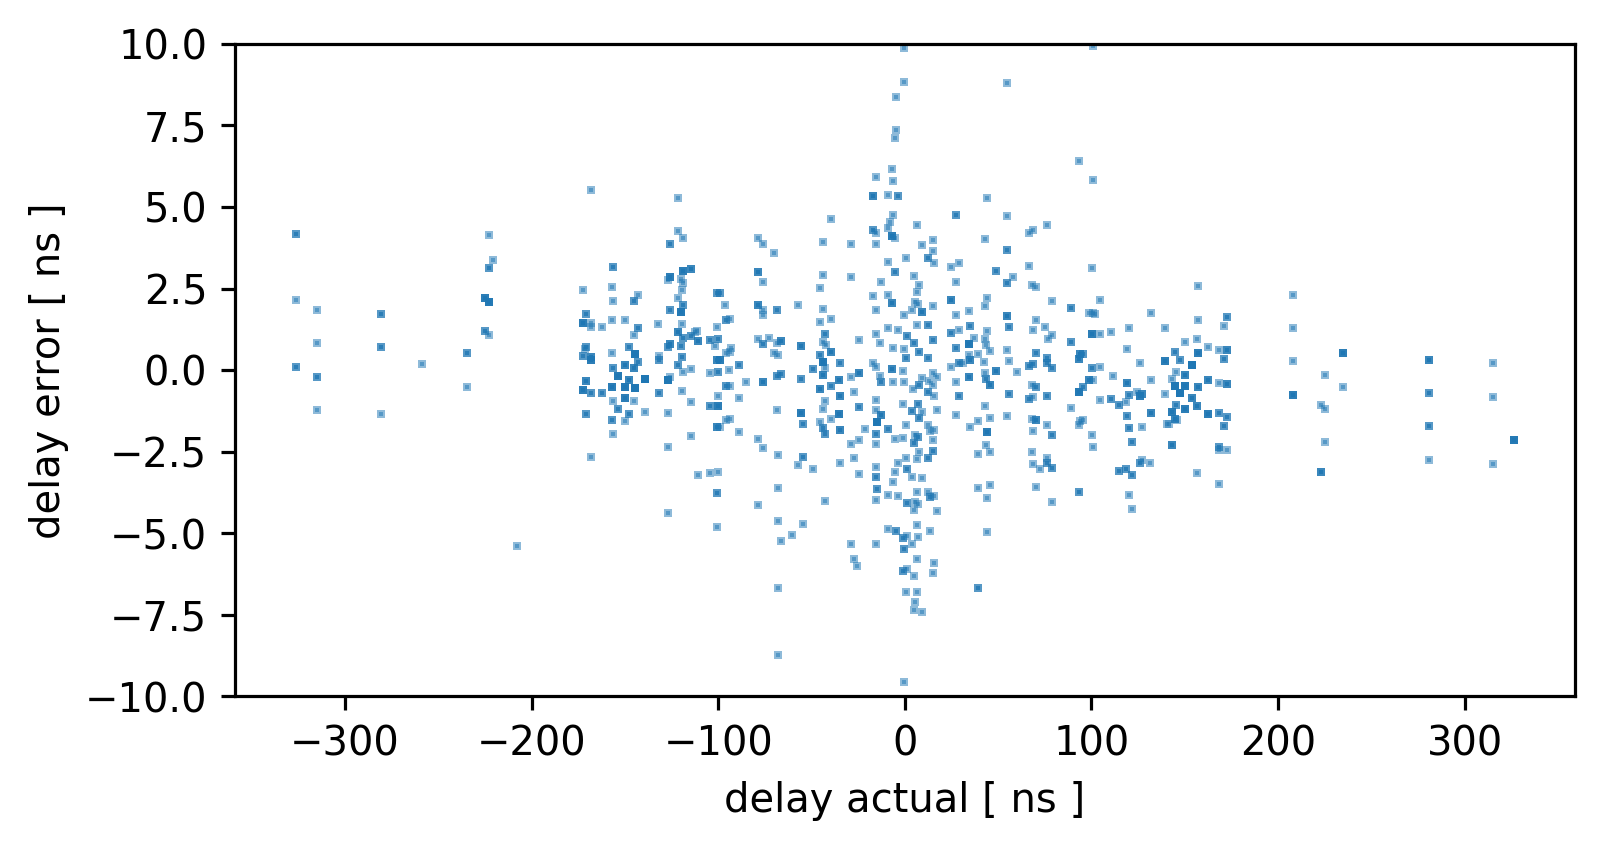

In [19]:
error = targets_ns - predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.plot(targets_ns, error, ls = 'none', marker = 's', markersize = 1, alpha = 0.5)
plt.xlabel('delay actual [ ns ]')
plt.ylabel('delay error [ ns ]')
plt.ylim(-10,10)
plt.show()

In [20]:
print('Standard deviation of error = {} ns'.format(np.std(error)))

abs_error = np.abs(error)
print('percent of absolute errors less than 1ns = {}%'.format(100*np.mean(abs_error < 1.)))
print('percent of absolute errors less than 5ns = {}%'.format(100*np.mean(abs_error < 5.)))
print('percent of absolute errors less than 7.5ns = {}%'.format(100*np.mean(abs_error < 7.5)))

Standard deviation of error = 3.36534778265 ns
percent of absolute errors less than 1ns = 43.5%
percent of absolute errors less than 5ns = 93.9%
percent of absolute errors less than 7.5ns = 98.4%


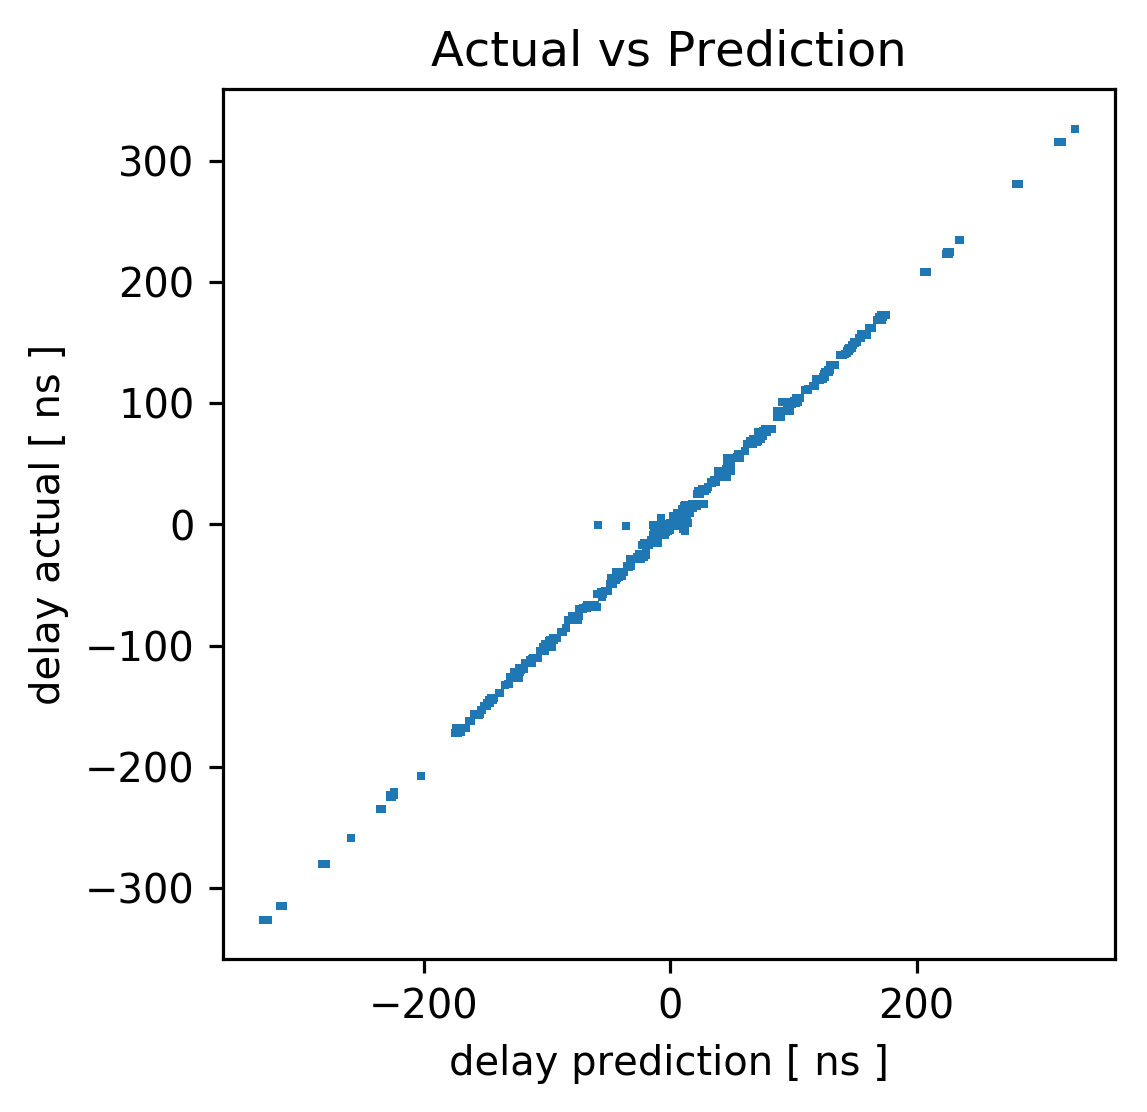

In [21]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 144)
plt.plot(predictions, targets_ns, ls = 'none', marker = 's', markersize = 1)
plt.title('Actual vs Prediction')
plt.xlabel('delay prediction [ ns ]')
plt.ylabel('delay actual [ ns ]')
plt.show()

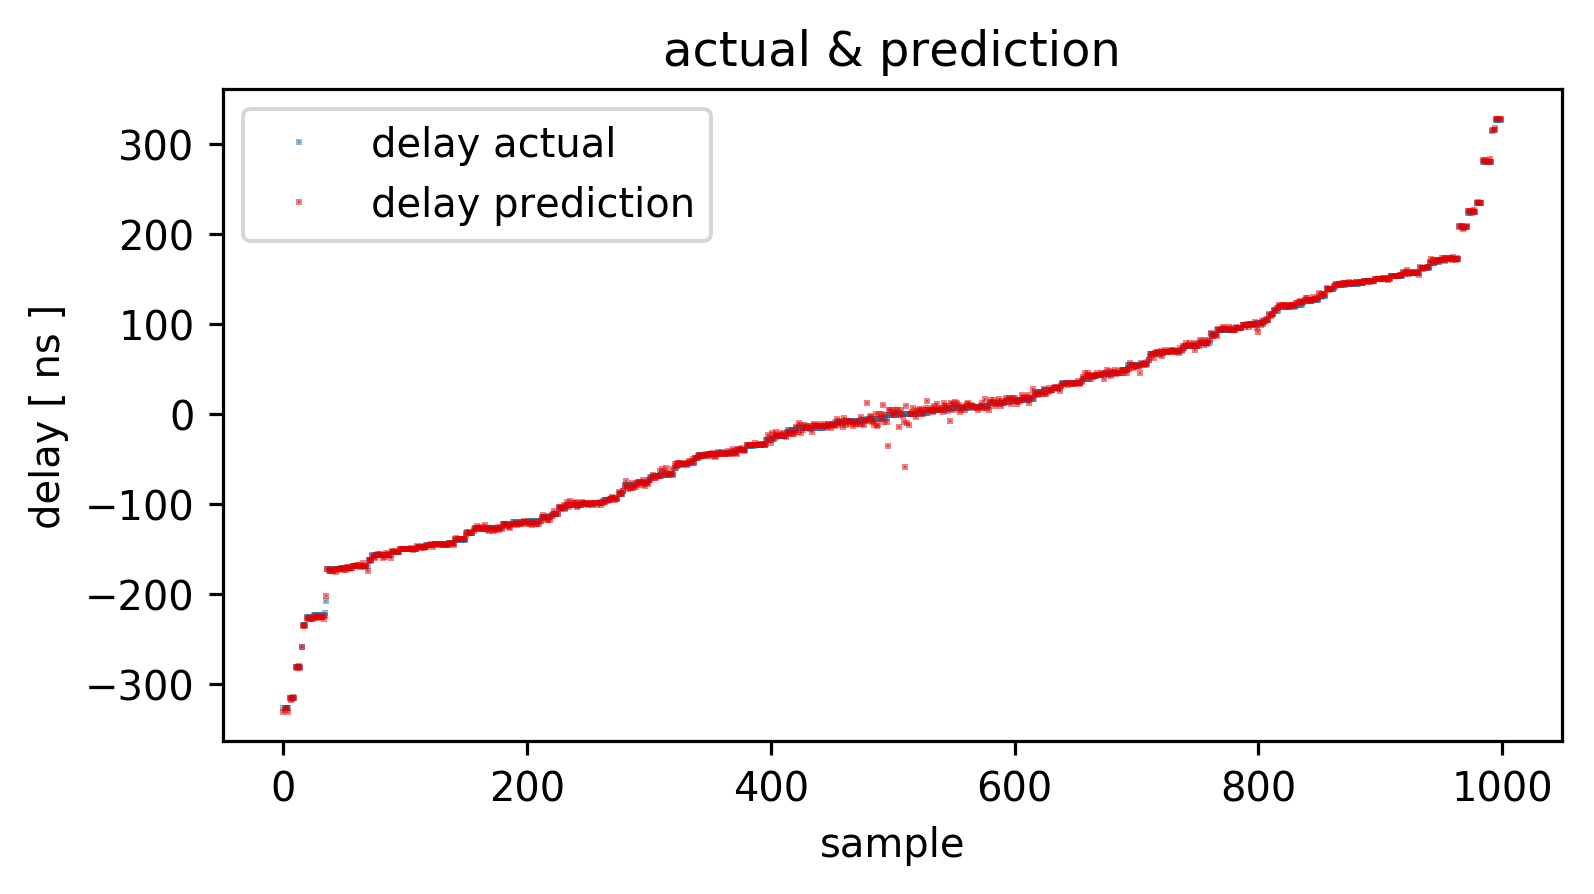

In [22]:
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
sorting_idx = np.argsort(targets_ns)
plt.plot(targets_ns[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5, label = 'delay actual')
plt.plot(predictions[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5,  label = 'delay prediction', c = '#E50000')
plt.xlabel('sample')
plt.ylabel('delay [ ns ]')
plt.title('actual & prediction')
plt.legend()
plt.show()

### Randomly choose some of the target / prediction pairs

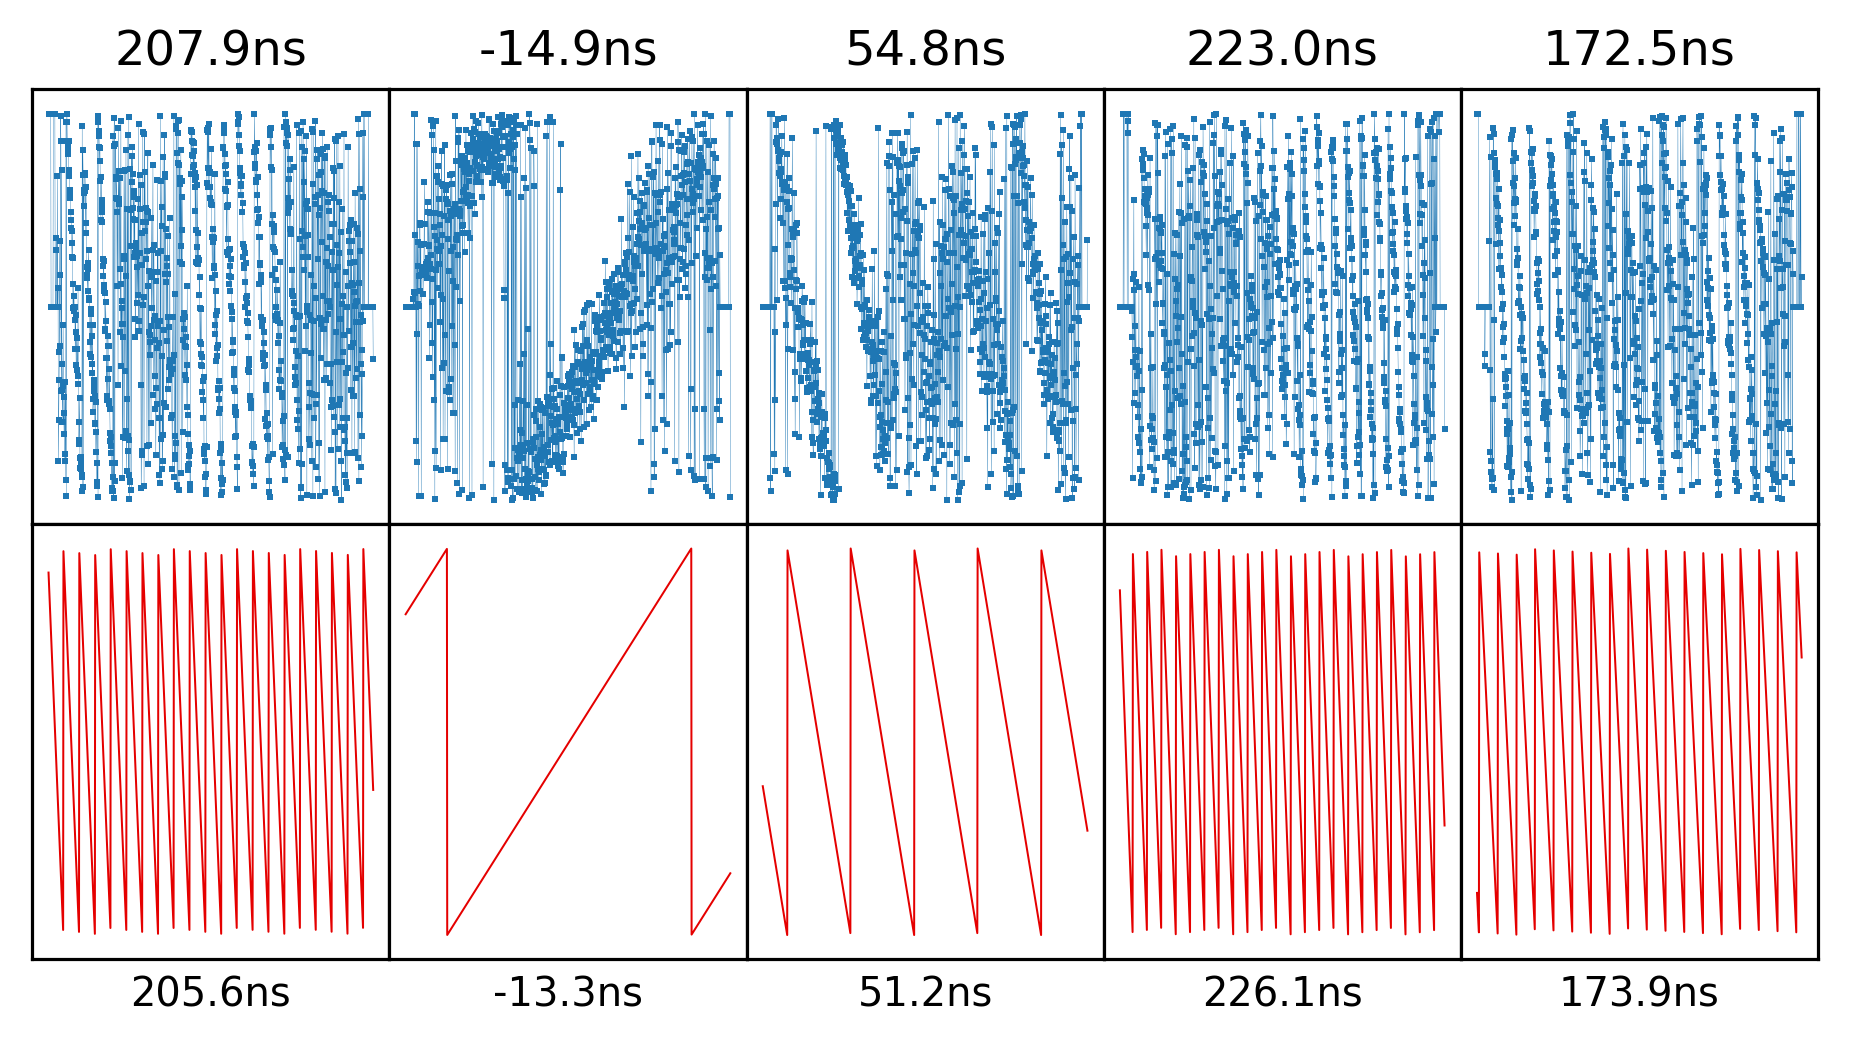

In [23]:
num_pairs = 5
fig, axes = plt.subplots(2,num_pairs, figsize = (8,4), dpi = 144)


for j in range(num_pairs):

    random_idx = np.random.randint(len(targets_ns))
    axes[0,j].plot(np.angle(waterfalls[random_idx]),lw = 0.1, marker = 's', markersize = 0.5)
    axes[0,j].set_title('{}ns'.format(np.round(targets_ns[random_idx],1)))

    estimated_line = np.angle(np.exp(-2j*np.pi*(np.linspace(0.1,0.2,1024)*predictions[random_idx]) + np.random.uniform()))
    axes[1,j].plot(estimated_line, lw = 0.5, c = '#E50000')
    axes[1,j].set_xlabel('{}ns'.format(np.round(predictions[random_idx],1)))

for ax in axes.flatten():
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_ylim(-np.pi - np.pi/8, np.pi + np.pi/8)
    
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()

Note the phase is not accounted for so the red lines will start at a different point in their cycle (here I have set the red line phase to be random)

***

## Contstruct testing data round 2

Generate waterfalls. Take ALL rows from each waterfall.
 - I didnt do this above because it takes 60x longer (60 rows per vis)

In [24]:
num_waterfalls = 100
waterfalls = []
targets = []

nu = np.arange(1024)
for i in range(num_waterfalls):
    
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]        
    
    true_delay = get_target(two_seps, generated_ant_delays)
    targets.append(true_delay)

    waterfall = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    waterfalls.append(waterfall)
 

## Predict cable delays for data

In [25]:
predictor = estdel.Delay(waterfalls)
predictions = predictor.predict()

## Convert

In [26]:
targets_ns = scale_delays_to_ns(np.array(targets), channel_width_in_GHz)

## Evaluate

For each waterfall make get a single prediction by taking the mean of its predictions

In [27]:
mean_predictions = np.mean(np.split(predictions, len(predictions)/60), axis = 1)

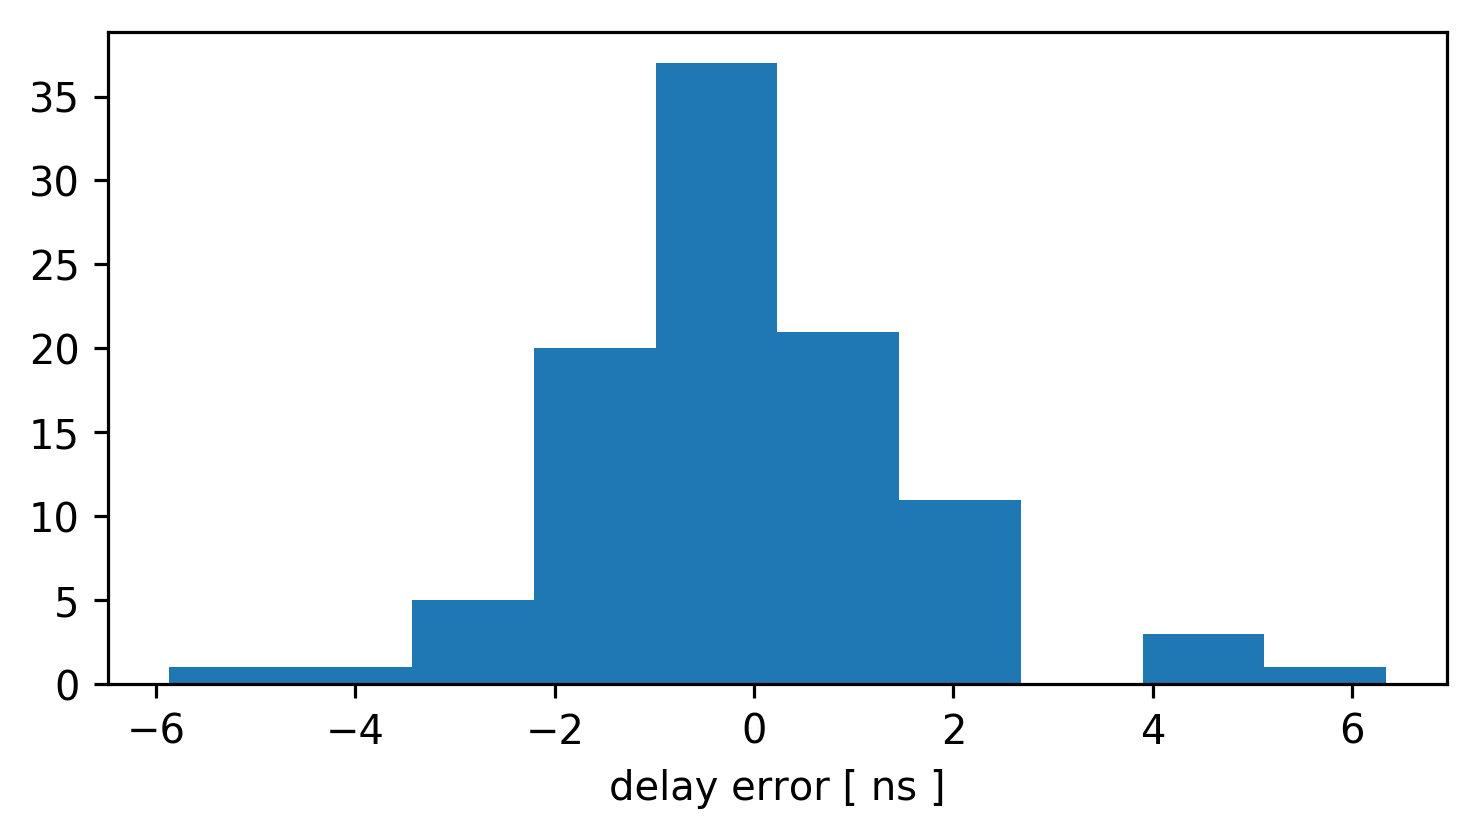

In [28]:
error = targets_ns - mean_predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.hist(error, bins = 10)
plt.xlabel('delay error [ ns ]')
plt.show()

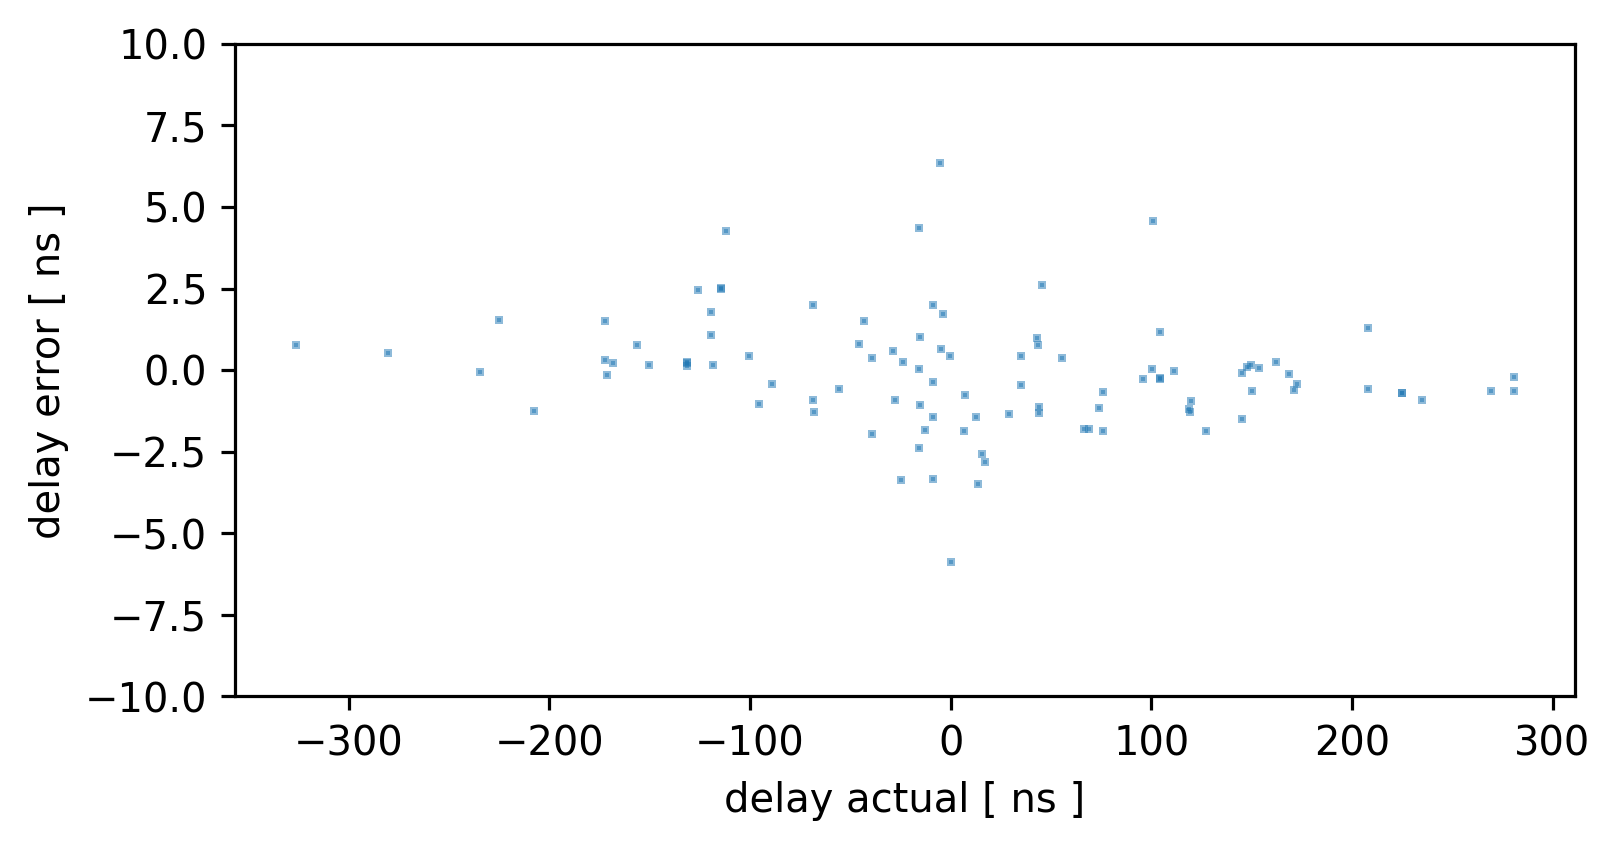

In [29]:
error = targets_ns - mean_predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.plot(targets_ns, error, ls = 'none', marker = 's', markersize = 1, alpha = 0.5)
plt.xlabel('delay actual [ ns ]')
plt.ylabel('delay error [ ns ]')
plt.ylim(-10,10)
plt.show()

In [30]:
print('Standard deviation of error = {} ns'.format(np.std(error)))

abs_error = np.abs(error)
print('percent of absolute errors less than 1ns = {}%'.format(100*np.mean(abs_error < 1.)))
print('percent of absolute errors less than 5ns = {}%'.format(100*np.mean(abs_error < 5.)))
print('percent of absolute errors less than 7.5ns = {}%'.format(100*np.mean(abs_error < 7.5)))

Standard deviation of error = 1.7272536155 ns
percent of absolute errors less than 1ns = 55.0%
percent of absolute errors less than 5ns = 98.0%
percent of absolute errors less than 7.5ns = 100.0%


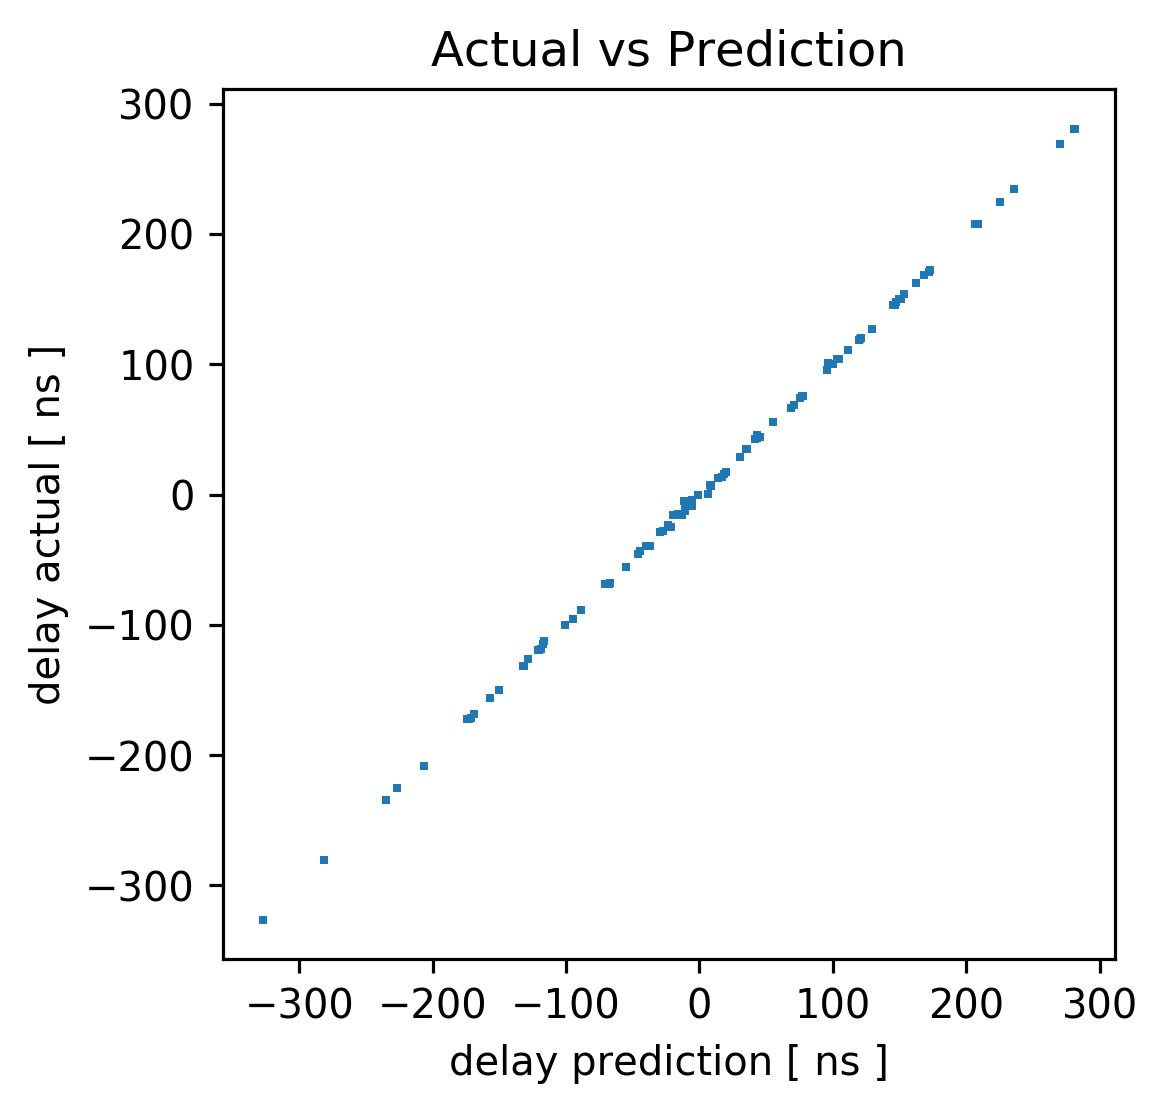

In [31]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 144)
plt.plot(mean_predictions, targets_ns, ls = 'none', marker = 's', markersize = 1)
plt.title('Actual vs Prediction')
plt.xlabel('delay prediction [ ns ]')
plt.ylabel('delay actual [ ns ]')
plt.show()

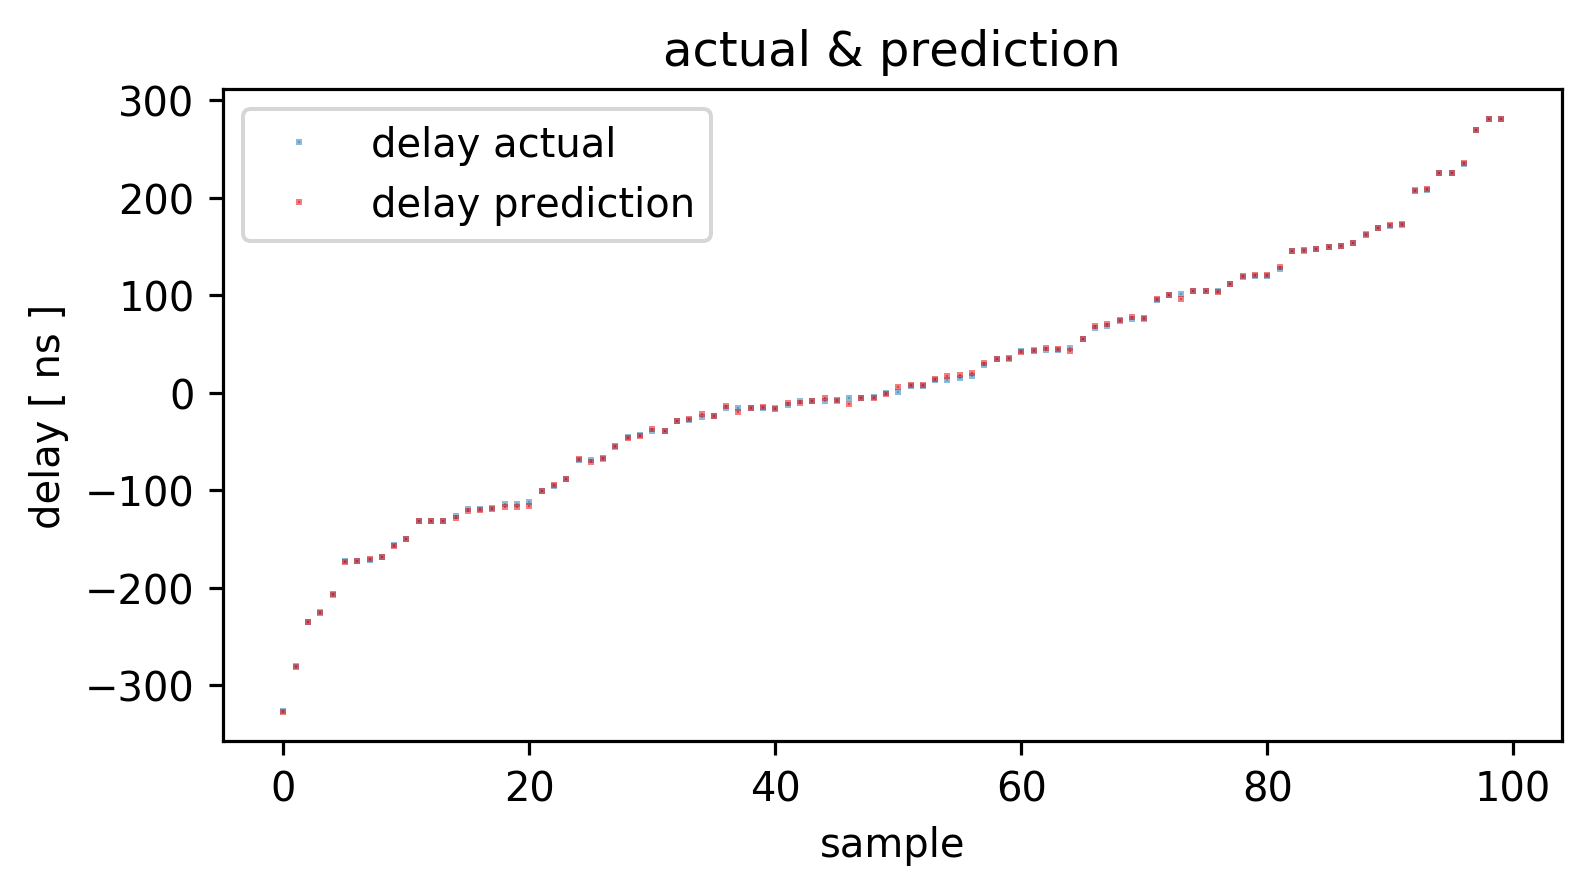

In [32]:
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
sorting_idx = np.argsort(targets_ns)
plt.plot(targets_ns[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5, label = 'delay actual')
plt.plot(mean_predictions[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5,  label = 'delay prediction',c = '#E50000')
plt.xlabel('sample')
plt.ylabel('delay [ ns ]')
plt.title('actual & prediction')
plt.legend()
plt.show()

### Same as previous except dont find the mean of each waterfalls prediction

In [33]:
targets_tiled_ns = [t for t in targets_ns for _ in range(60)]

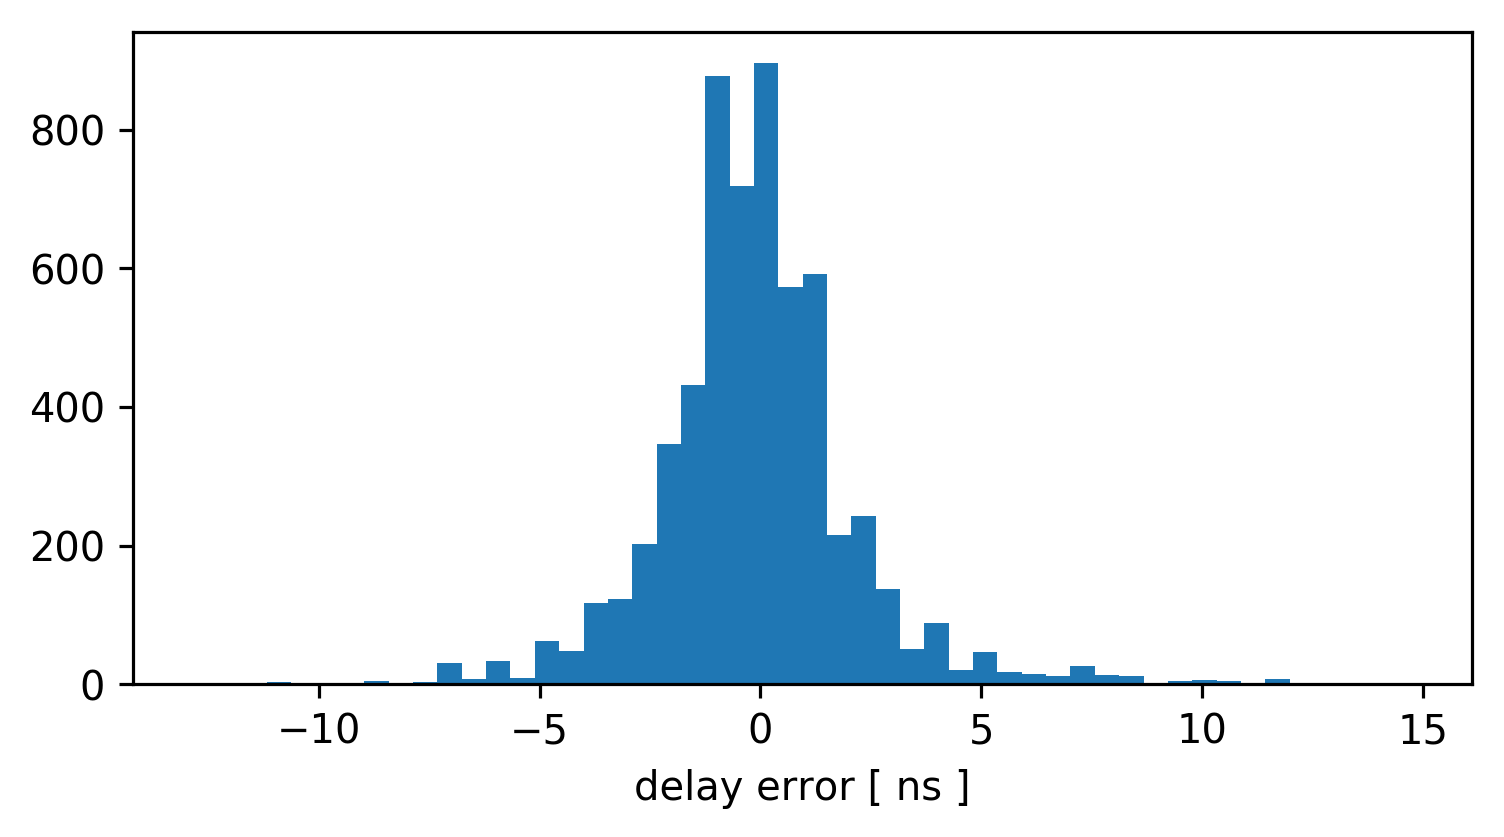

In [34]:
error = targets_tiled_ns - predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.hist(error, bins = 50)
plt.xlabel('delay error [ ns ]')
plt.show()

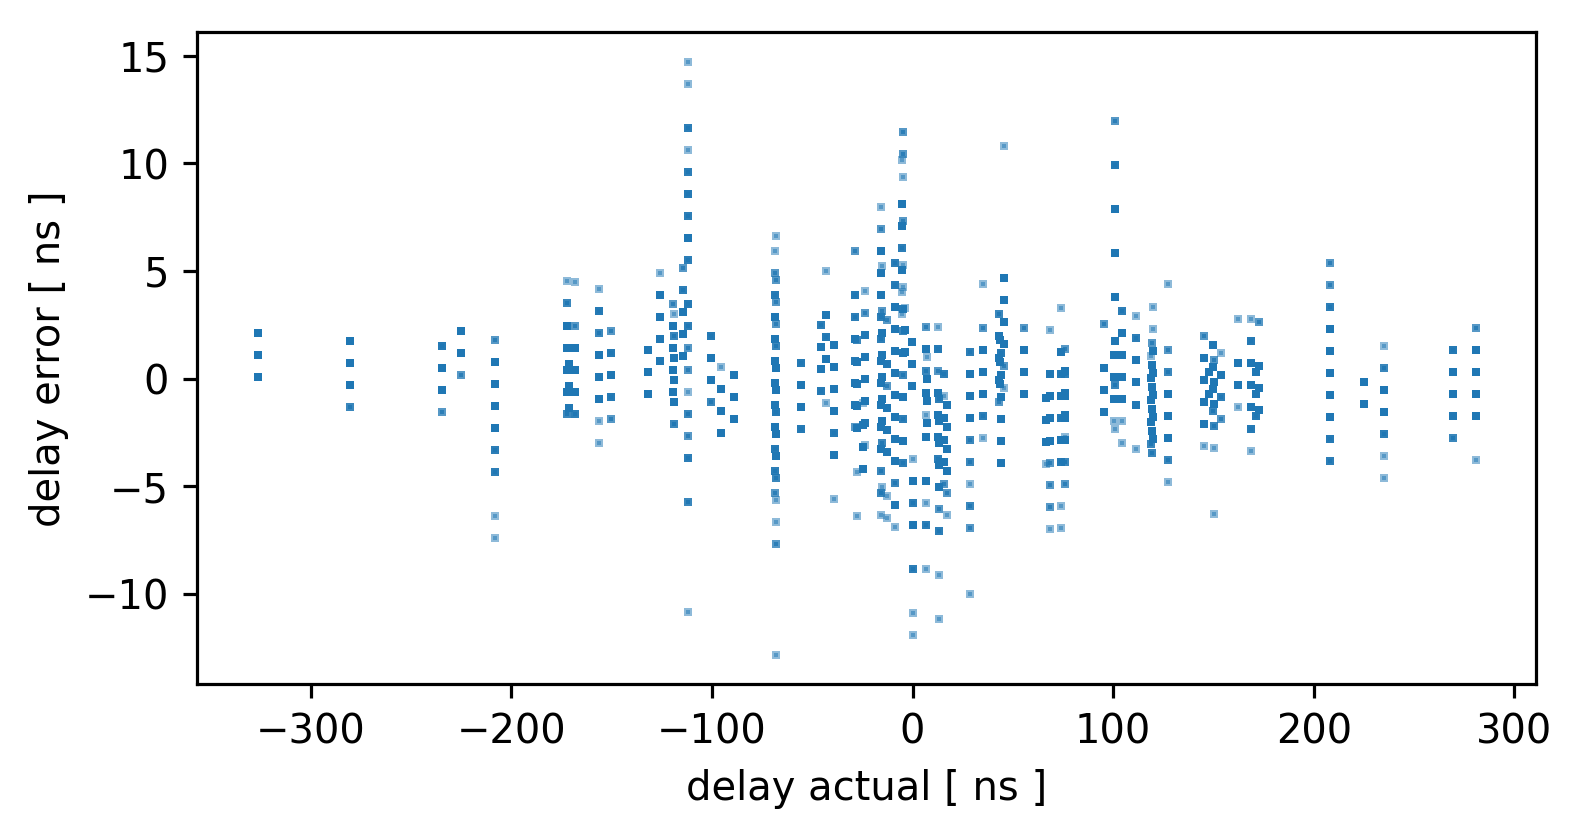

In [35]:
error = targets_tiled_ns - predictions
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
plt.plot(targets_tiled_ns, error, ls = 'none', marker = 's', markersize = 1, alpha = 0.5)
plt.xlabel('delay actual [ ns ]')
plt.ylabel('delay error [ ns ]')
# plt.ylim(-10,10)
plt.show()

In [36]:
print('Standard deviation of error = {} ns'.format(np.std(error)))

abs_error = np.abs(error)
print('percent of absolute errors less than 1ns = {}%'.format(100*np.mean(abs_error < 1.)))
print('percent of absolute errors less than 5ns = {}%'.format(100*np.mean(abs_error < 5.)))
print('percent of absolute errors less than 7.5ns = {}%'.format(100*np.mean(abs_error < 7.5)))

Standard deviation of error = 2.23302887417 ns
percent of absolute errors less than 1ns = 47.45%
percent of absolute errors less than 5ns = 95.8833333333%
percent of absolute errors less than 7.5ns = 98.9333333333%


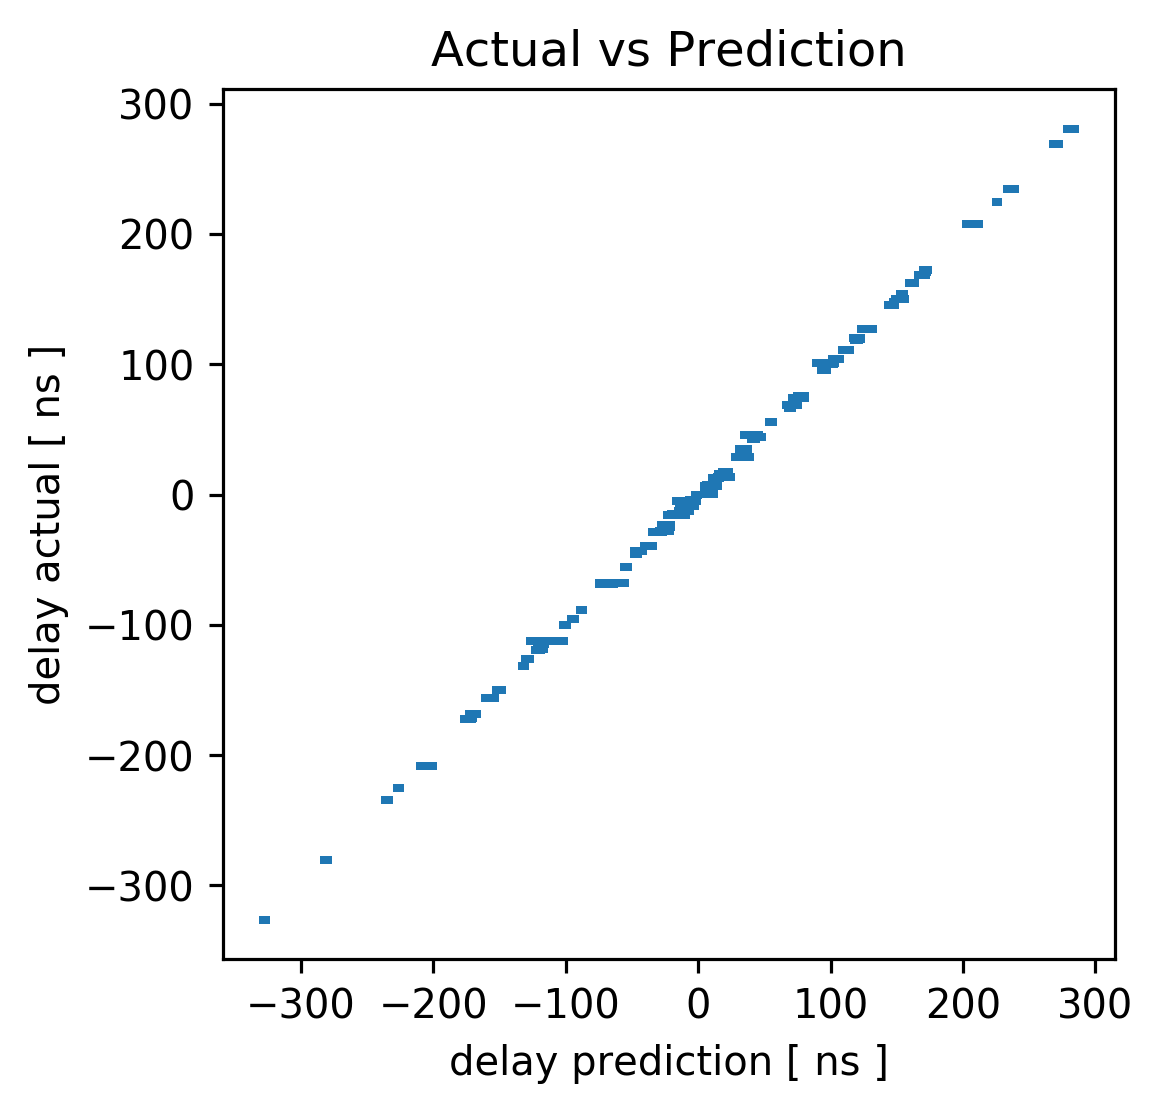

In [37]:
fig, ax = plt.subplots(figsize = (4,4), dpi = 144)
plt.plot(predictions, targets_tiled_ns, ls = 'none', marker = 's', markersize = 1)
plt.title('Actual vs Prediction')
plt.xlabel('delay prediction [ ns ]')
plt.ylabel('delay actual [ ns ]')
plt.show()

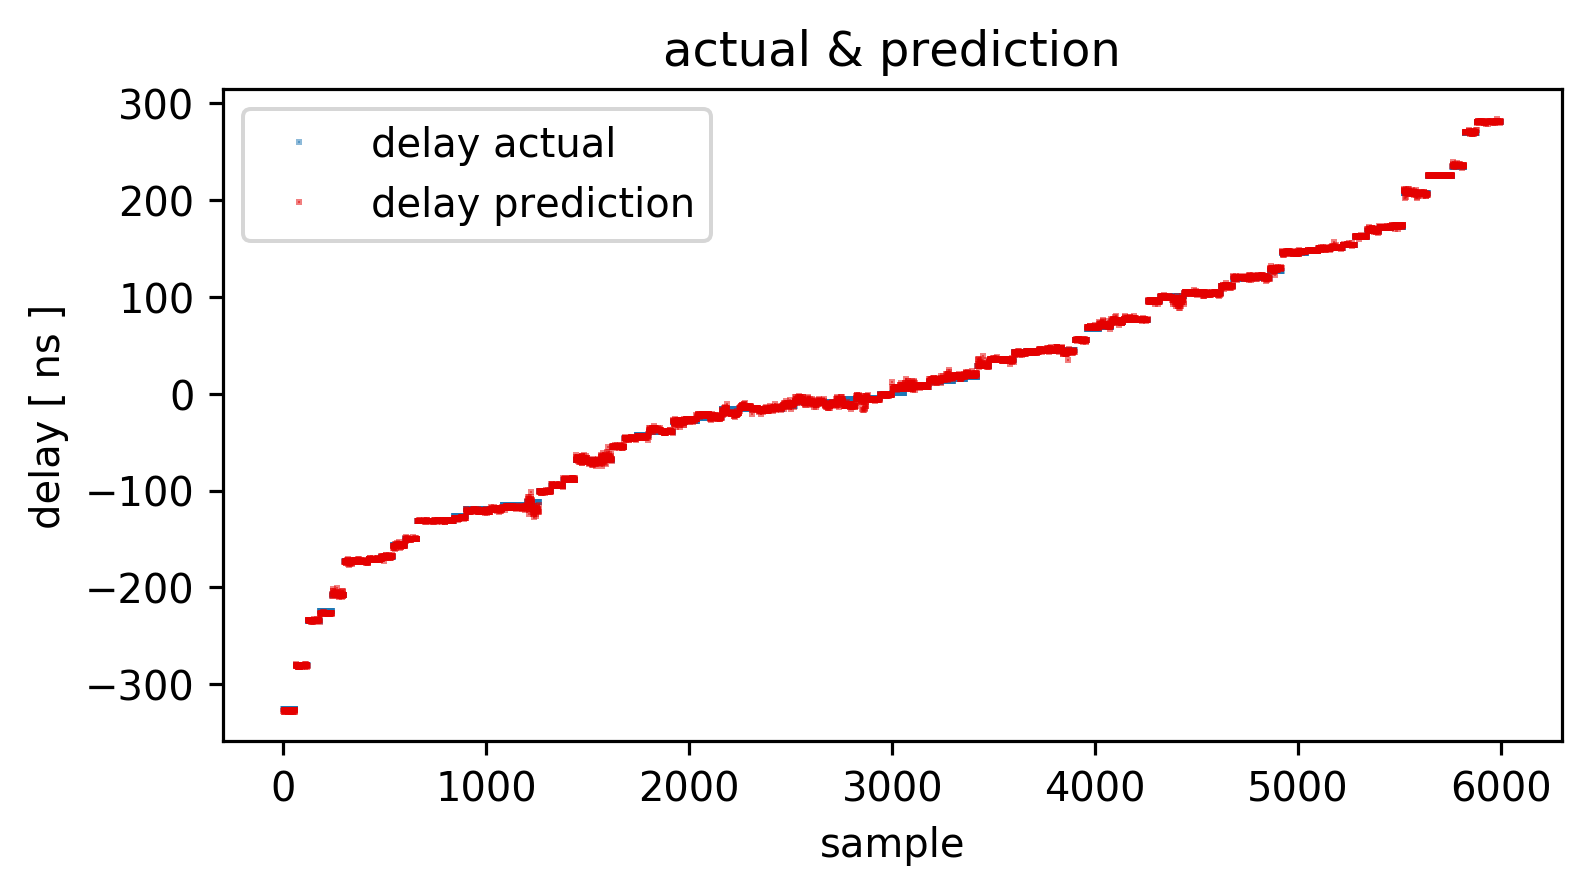

In [38]:
fig, ax = plt.subplots(figsize = (6,3), dpi = 144)
sorting_idx = np.argsort(targets_tiled_ns)
plt.plot(np.array(targets_tiled_ns)[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5, label = 'delay actual')
plt.plot(predictions[sorting_idx], ls = 'none', marker = 's', markersize = 0.5, alpha = 0.5,  label = 'delay prediction', c = '#E50000')
plt.xlabel('sample')
plt.ylabel('delay [ ns ]')
plt.title('actual & prediction')
plt.legend()
plt.show()

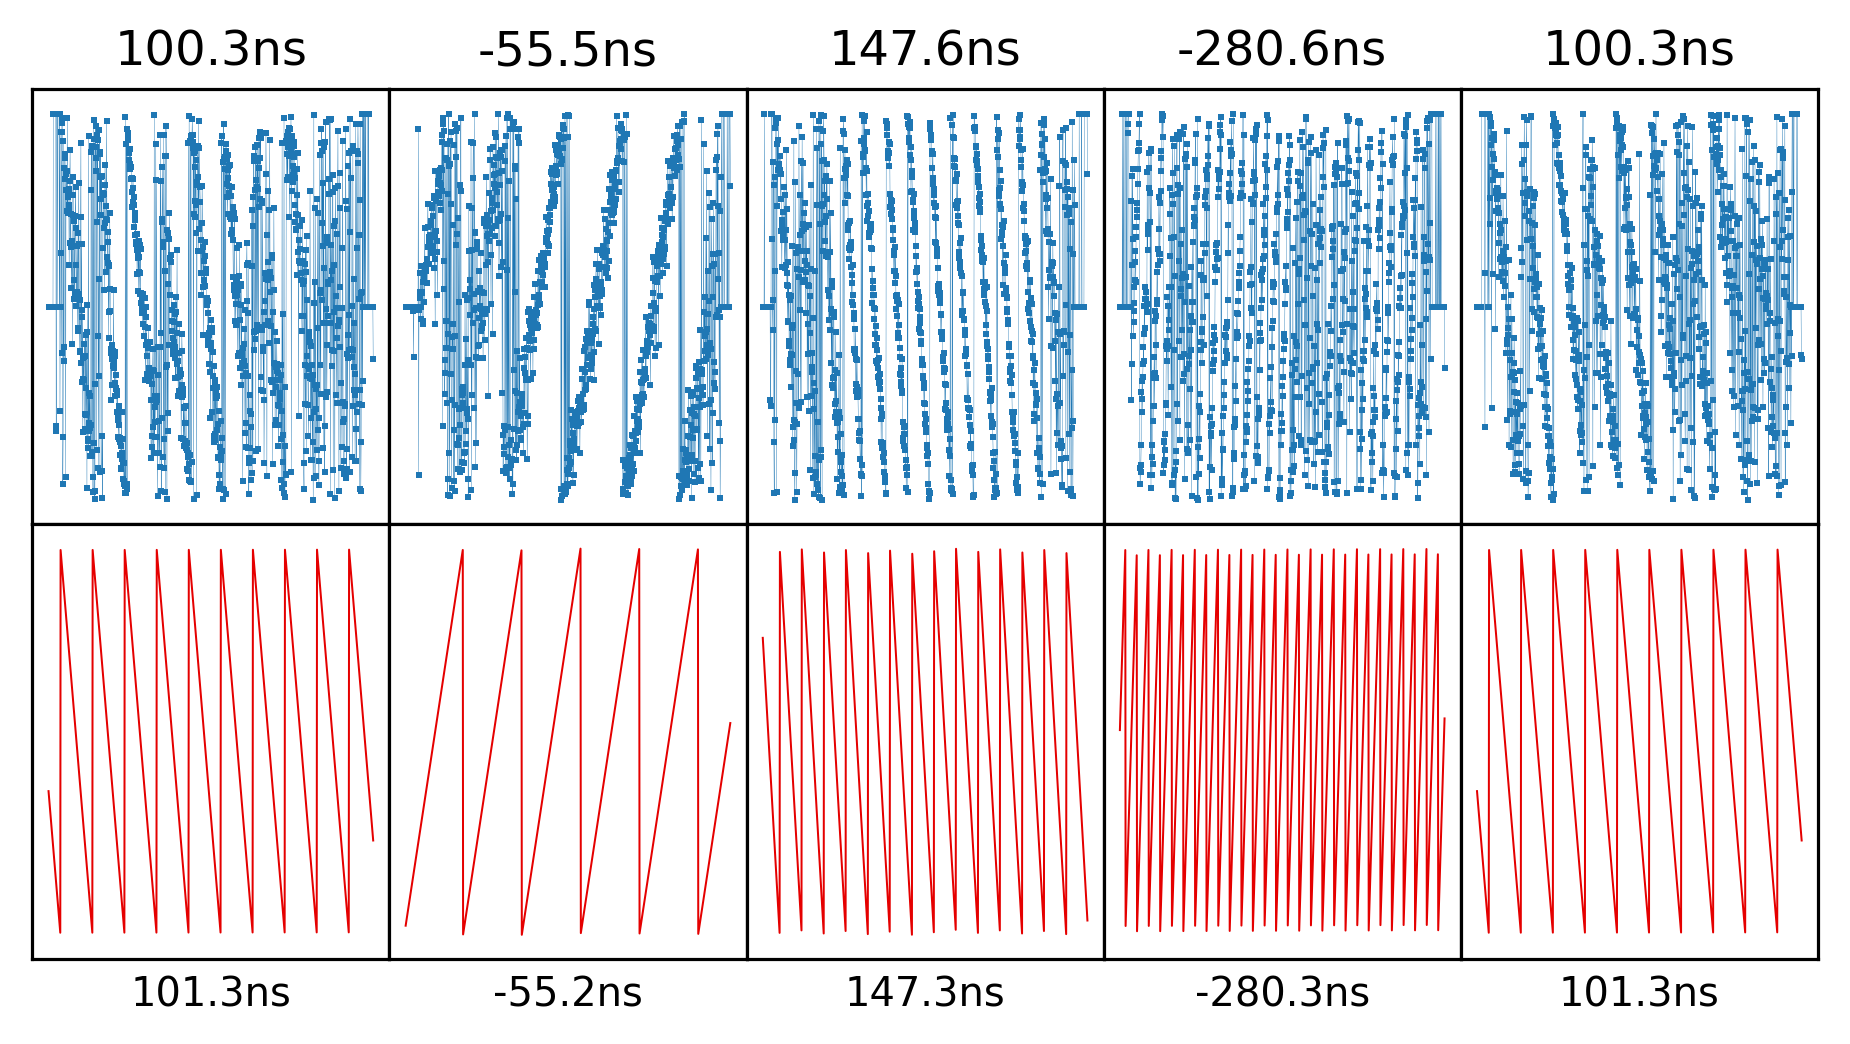

In [39]:
num_pairs = 5
fig, axes = plt.subplots(2,num_pairs, figsize = (8,4), dpi = 144)
targets_tiled = [t for t in targets for _ in range(60)]
for j in range(num_pairs):

    random_idx = np.random.randint(len(targets_tiled_ns))
    axes[0,j].plot(np.angle(np.array(waterfalls).reshape(-1,1024)[random_idx]),lw = 0.1, marker = 's', markersize = 0.5)
    axes[0,j].set_title('{}ns'.format(np.round(targets_tiled_ns[random_idx],1)))

    estimated_line = np.angle(np.exp(-2j*np.pi*(np.linspace(0.1,0.2,1024)*predictions[random_idx]) + np.random.uniform()))
    axes[1,j].plot(estimated_line, lw = 0.5, c = '#E50000')
    axes[1,j].set_xlabel('{}ns'.format(np.round(predictions[random_idx],1)))

for ax in axes.flatten():
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_ylim(-np.pi - np.pi/8, np.pi + np.pi/8)
    
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()